# Libaries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.preprocessing import KBinsDiscretizer
from sklearn.impute import SimpleImputer

from scipy.stats import ks_2samp
from varclushi import VarClusHi
from sklearn.feature_selection import VarianceThreshold

from sklearn.model_selection import train_test_split

In [2]:
pd.set_option('display.max_columns',500)

# Functions

In [3]:
# Requencies
def freq(df, var):
    if type(var) != list:
        var = [var]
    
    for v in var:
        aux = df[v].value_counts().to_frame().rename(columns={v:'FA'})
        aux['FR'] = aux['FA'] / aux['FA'].sum()
        aux[['FAA','FRA']] = aux.apply( np.cumsum )
        print(f"Frequencies table for variable {v} \n")    
        print(aux,"\n")

In [4]:
#Normalize
def normalize(df, v, umbral):
    #
    aux = df[v].value_counts(True).to_frame()
    aux[f'n_{v}'] = np.where( aux[v] < umbral , 'SMALL_CATEGORIES', aux.index   )
    moda = aux.head(1)[f'n_{v}'].values[0]
    if aux.loc[aux[f'n_{v}'] == 'SMALL_CATEGORIES'][v].sum() < umbral: 
        aux[f'n_{v}'].replace({'SMALL_CATEGORIES':moda},inplace=True)

    aux.drop(v,axis=1, inplace=True)
    aux.reset_index(inplace=True)

    return df.merge(aux, left_on=[v], right_on='index',how='inner').drop('index',axis=1)

In [5]:
#Discretizing
def discretizar(df,v,k):
    
    kb = KBinsDiscretizer( n_bins= k , encode='ordinal', strategy='kmeans')
    kb.fit( df[[v]] )
    df[f'd_{v}_{k}']  = pd.cut( df[v], bins=kb.bin_edges_[0] , include_lowest=True  ).astype(str)
    
    return df

In [6]:
def calculo_iv(df, v, tgt , um):
    aux = df.pivot_table( index = v , 
                          columns = tgt , 
                          values = um , 
                         aggfunc = 'count', 
                         fill_value = 0 )
    
    aux[list(range(2))] = aux/aux.apply(np.sum)
    aux['w'] = np.log( aux[0] / aux[1] )
    aux['iv'] = ( aux[0] - aux[1] ) * aux['w']
    
    return v, aux['iv'].sum()

In [7]:
def codificacion_woe(df,v,tgt,um):
    
    aux = df.pivot_table(index=v,
                         columns=tgt,
                         values=um,
                         aggfunc='count',
                         fill_value=0)
    
    aux[list(range(2))] = aux/aux.apply(np.sum)
    
    aux['w'] = np.log(aux[0]/aux[1])
    
    aux.drop(range(2),axis=1,inplace=True)
    
    aux = aux.to_dict()['w']
    
    return v,aux

# Data Reading

In [8]:
df = pd.read_csv("../Datasets/Examen/diabetes_examen/diabetes.csv")

In [9]:
df.head()

,id,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide.metformin,glipizide.metformin,glimepiride.pioglitazone,metformin.rosiglitazone,metformin.pioglitazone,change,diabetesMed,readmitted
0,1,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,?,?,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,2,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,3,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,4,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,5,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO


# Cleaning / pre-treatment

In [10]:
df.shape, len(df.id.unique())

((101766, 51), 101766)

In [11]:
#We can drop the id column as it is the same as the index
#We can also drop "encounter_id" as it is the id at the hospital and not the id of the customer
df.id

0              1
1              2
2              3
3              4
4              5
           ...  
101761    101762
101762    101763
101763    101764
101764    101765
101765    101766
Name: id, Length: 101766, dtype: int64

In [12]:
#We're not using Patient Number as um as it can affect our analysis in the predictive power
#Instead, we're using each admission to the hospital as um (encounter_id)
df.drop(columns=["id", "patient_nbr"], inplace=True)
#df.rename(columns={"patient_nbr": "patientID"}, inplace=True)
df.columns = [c.replace('.','_') for c in df.columns.tolist()]

In [13]:
#We replace the ? value for nan
df = df.replace("?", np.nan)

In [14]:
df.head()

,encounter_id,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide_metformin,glipizide_metformin,glimepiride_pioglitazone,metformin_rosiglitazone,metformin_pioglitazone,change,diabetesMed,readmitted
0,2278392,Caucasian,Female,[0-10),NaN,6,25,1,1,NaN,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,NaN,NaN,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,149190,Caucasian,Female,[10-20),NaN,1,1,7,3,NaN,NaN,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,NaN,NaN,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,500364,Caucasian,Male,[30-40),NaN,1,1,7,2,NaN,NaN,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,Caucasian,Male,[40-50),NaN,1,1,7,1,NaN,NaN,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [15]:
um = ["encounter_id"]
tgt = ["diabetesMed"]
vard = ["race", "gender", "age", "weight", "payer_code", "medical_specialty", "max_glu_serum", "A1Cresult", "metformin", "repaglinide",
        "nateglinide", "chlorpropamide", "glimepiride", "acetohexamide", "glipizide", "glyburide", "tolbutamide", "pioglitazone", "rosiglitazone",
        "acarbose", "miglitol", "troglitazone", "tolazamide", "examide", "citoglipton", "insulin", "glyburide_metformin", "glipizide_metformin",
        "glimepiride_pioglitazone", "metformin_rosiglitazone", "metformin_pioglitazone", "change", "readmitted"]
varc = [c for c in df.columns.tolist() if c not in vard]
varc = [c for c in varc if c not in um]
varc = [c for c in varc if c not in tgt]

In [16]:
df[varc].dtypes

admission_type_id            int64
discharge_disposition_id     int64
admission_source_id          int64
time_in_hospital             int64
num_lab_procedures           int64
num_procedures               int64
num_medications              int64
number_outpatient            int64
number_emergency             int64
number_inpatient             int64
diag_1                      object
diag_2                      object
diag_3                      object
number_diagnoses             int64
dtype: object

In [17]:
df[vard].dtypes

race                        object
gender                      object
age                         object
weight                      object
payer_code                  object
medical_specialty           object
max_glu_serum               object
A1Cresult                   object
metformin                   object
repaglinide                 object
nateglinide                 object
chlorpropamide              object
glimepiride                 object
acetohexamide               object
glipizide                   object
glyburide                   object
tolbutamide                 object
pioglitazone                object
rosiglitazone               object
acarbose                    object
miglitol                    object
troglitazone                object
tolazamide                  object
examide                     object
citoglipton                 object
insulin                     object
glyburide_metformin         object
glipizide_metformin         object
glimepiride_pioglita

In [18]:
#We need to change the type for diag_x columns but some values start with V or E
temp = ["diag_1", "diag_2", "diag_3"]
for col in temp:
    df[col] = df[col].apply(lambda x : x[1:] if str(x).startswith(("V","E")) else x)

df = df.astype({'diag_1':'float','diag_2':'float','diag_3':'float'})

# Exploratory Analysis

## Discrete Variables

### Replacing NaN for "SIN CATEGORIA"

In [19]:
df.shape

(101766, 49)

In [20]:
for v in vard:
    df[v] = df[v].fillna("SIN CATEGORIA")

### Frequencies

In [21]:
for v in vard:
    freq(df,v)

Frequencies table for variable race 

                    FA        FR     FAA       FRA
Caucasian        76099  0.747784   76099  0.747784
AfricanAmerican  19210  0.188766   95309  0.936551
SIN CATEGORIA     2273  0.022336   97582  0.958886
Hispanic          2037  0.020017   99619  0.978903
Other             1506  0.014799  101125  0.993701
Asian              641  0.006299  101766  1.000000 

Frequencies table for variable gender 

                    FA        FR     FAA       FRA
Female           54708  0.537586   54708  0.537586
Male             47055  0.462384  101763  0.999971
Unknown/Invalid      3  0.000029  101766  1.000000 

Frequencies table for variable age 

             FA        FR     FAA       FRA
[70-80)   26068  0.256156   26068  0.256156
[60-70)   22483  0.220928   48551  0.477085
[50-60)   17256  0.169565   65807  0.646650
[80-90)   17197  0.168986   83004  0.815636
[40-50)    9685  0.095169   92689  0.910805
[30-40)    3775  0.037095   96464  0.947900
[90-100)   2

### Normalizing

In [22]:
for v in vard:
    df = normalize(df,v,0.05)

In [23]:
df.head()

,encounter_id,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide_metformin,glipizide_metformin,glimepiride_pioglitazone,metformin_rosiglitazone,metformin_pioglitazone,change,diabetesMed,readmitted,n_race,n_gender,n_age,n_weight,n_payer_code,n_medical_specialty,n_max_glu_serum,n_A1Cresult,n_metformin,n_repaglinide,n_nateglinide,n_chlorpropamide,n_glimepiride,n_acetohexamide,n_glipizide,n_glyburide,n_tolbutamide,n_pioglitazone,n_rosiglitazone,n_acarbose,n_miglitol,n_troglitazone,n_tolazamide,n_examide,n_citoglipton,n_insulin,n_glyburide_metformin,n_glipizide_metformin,n_glimepiride_pioglitazone,n_metformin_rosiglitazone,n_metformin_pioglitazone,n_change,n_readmitted
0,2278392,Caucasian,Female,[0-10),SIN CATEGORIA,6,25,1,1,SIN CATEGORIA,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,NaN,NaN,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO,Caucasian,Female,SMALL_CATEGORIES,SIN CATEGORIA,SIN CATEGORIA,SMALL_CATEGORIES,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,53963346,Caucasian,Female,[0-10),SIN CATEGORIA,3,1,1,2,SIN CATEGORIA,Pediatrics-Endocrinology,3,0,3,0,0,0,250.02,276.0,79.0,3,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO,Caucasian,Female,SMALL_CATEGORIES,SIN CATEGORIA,SIN CATEGORIA,SMALL_CATEGORIES,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
2,42008934,Caucasian,Male,[0-10),SIN CATEGORIA,1,1,7,1,SIN CATEGORIA,Pediatrics-Endocrinology,50,0,8,0,0,0,250.13,276.0,NaN,2,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO,Caucasian,Male,SMALL_CATEGORIES,SIN CATEGORIA,SIN CATEGORIA,SMALL_CATEGORIES,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
3,68750328,Caucasian,Male,[0-10),SIN CATEGORIA,1,1,7,1,SIN CATEGORIA,Pediatrics-Endocrinology,33,0,4,0,0,0,250.13,276.0,558.0,3,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO,Caucasian,Male,SMALL_CATEGORIES,SIN CATEGORIA,SIN CATEGORIA,SMALL_CATEGORIES,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
4,13138032,Caucasian,Female,[10-20),SIN CATEGORIA,2,1,1,2,SIN CATEGORIA,Pediatrics-Endocrinology,13,0,1,0,0,0,250.03,278.0,NaN,2,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO,Caucasian,Female,SMALL_CATEGORIES,SIN CATEGORIA,SIN CATEGORIA,SMALL_CATEGORIES,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO


In [24]:
varn = [c for c in df.filter(like='n_').columns.tolist() if c[:2] == 'n_' ]
varn

['n_race',
 'n_gender',
 'n_age',
 'n_weight',
 'n_payer_code',
 'n_medical_specialty',
 'n_max_glu_serum',
 'n_A1Cresult',
 'n_metformin',
 'n_repaglinide',
 'n_nateglinide',
 'n_chlorpropamide',
 'n_glimepiride',
 'n_acetohexamide',
 'n_glipizide',
 'n_glyburide',
 'n_tolbutamide',
 'n_pioglitazone',
 'n_rosiglitazone',
 'n_acarbose',
 'n_miglitol',
 'n_troglitazone',
 'n_tolazamide',
 'n_examide',
 'n_citoglipton',
 'n_insulin',
 'n_glyburide_metformin',
 'n_glipizide_metformin',
 'n_glimepiride_pioglitazone',
 'n_metformin_rosiglitazone',
 'n_metformin_pioglitazone',
 'n_change',
 'n_readmitted']

In [25]:
df.shape

(101766, 82)

In [26]:
for v in varn:
    freq(df, v)

Frequencies table for variable n_race 

                     FA        FR     FAA       FRA
Caucasian         76099  0.747784   76099  0.747784
AfricanAmerican   19210  0.188766   95309  0.936551
SMALL_CATEGORIES   6457  0.063449  101766  1.000000 

Frequencies table for variable n_gender 

           FA        FR     FAA       FRA
Female  54711  0.537616   54711  0.537616
Male    47055  0.462384  101766  1.000000 

Frequencies table for variable n_age 

                     FA        FR     FAA       FRA
[70-80)           26068  0.256156   26068  0.256156
[60-70)           22483  0.220928   48551  0.477085
[50-60)           17256  0.169565   65807  0.646650
[80-90)           17197  0.168986   83004  0.815636
[40-50)            9685  0.095169   92689  0.910805
SMALL_CATEGORIES   9077  0.089195  101766  1.000000 

Frequencies table for variable n_weight 

                   FA   FR     FAA  FRA
SIN CATEGORIA  101766  1.0  101766  1.0 

Frequencies table for variable n_payer_code 

     

### Unary Variables

In [27]:
unary = [c for c, count in zip(varn, [df[v].unique().shape[0] for v in varn]) if count == 1]

In [28]:
varn = [v for v in varn if v not in unary]
len(varn) , varn

(16,
 ['n_race',
  'n_gender',
  'n_age',
  'n_payer_code',
  'n_medical_specialty',
  'n_max_glu_serum',
  'n_A1Cresult',
  'n_metformin',
  'n_glimepiride',
  'n_glipizide',
  'n_glyburide',
  'n_pioglitazone',
  'n_rosiglitazone',
  'n_insulin',
  'n_change',
  'n_readmitted'])

## Countinuous Variables

In [29]:
df.shape

(101766, 82)

In [30]:
X = df[varc].copy()

In [31]:
X.shape

(101766, 14)

### Univariate Analysis

In [32]:
X.describe(percentiles=[0.01,0.1,0.9,0.99])

,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses
count,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101745.000000,101408.000000,100343.000000,101766.000000
mean,2.024006,3.715642,5.754437,4.395987,43.095641,1.339730,16.021844,0.369357,0.197836,0.635566,486.530398,434.969697,409.669227,7.422607
std,1.445403,5.280166,4.064081,2.985108,19.674362,1.705807,8.127566,1.267265,0.930472,1.262863,212.307214,188.312315,194.995440,1.933600
min,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,3.000000,2.000000,1.000000,1.000000
1%,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,3.000000,0.000000,0.000000,0.000000,38.000000,38.000000,15.000000,2.000000
10%,1.000000,1.000000,1.000000,1.000000,14.000000,0.000000,7.000000,0.000000,0.000000,0.000000,250.120000,250.000000,250.000000,5.000000
50%,1.000000,1.000000,7.000000,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,435.000000,425.000000,402.000000,8.000000
90%,5.000000,7.000000,7.000000,9.000000,67.000000,4.000000,26.000000,1.000000,1.000000,2.000000,786.000000,707.000000,707.000000,9.000000
99%,6.000000,25.000000,17.000000,14.000000,85.000000,6.000000,43.000000,5.000000,3.000000,6.000000,997.000000,996.000000,995.000000,9.000000
max,8.000000,28.000000,25.000000,14.000000,132.000000,6.000000,81.000000,42.000000,76.000000,21.000000,999.000000,999.000000,999.000000,16.000000


array([[<AxesSubplot:title={'center':'admission_type_id'}>,
        <AxesSubplot:title={'center':'discharge_disposition_id'}>,
        <AxesSubplot:title={'center':'admission_source_id'}>,
        <AxesSubplot:title={'center':'time_in_hospital'}>],
       [<AxesSubplot:title={'center':'num_lab_procedures'}>,
        <AxesSubplot:title={'center':'num_procedures'}>,
        <AxesSubplot:title={'center':'num_medications'}>,
        <AxesSubplot:title={'center':'number_outpatient'}>],
       [<AxesSubplot:title={'center':'number_emergency'}>,
        <AxesSubplot:title={'center':'number_inpatient'}>,
        <AxesSubplot:title={'center':'diag_1'}>,
        <AxesSubplot:title={'center':'diag_2'}>],
       [<AxesSubplot:title={'center':'diag_3'}>,
        <AxesSubplot:title={'center':'number_diagnoses'}>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

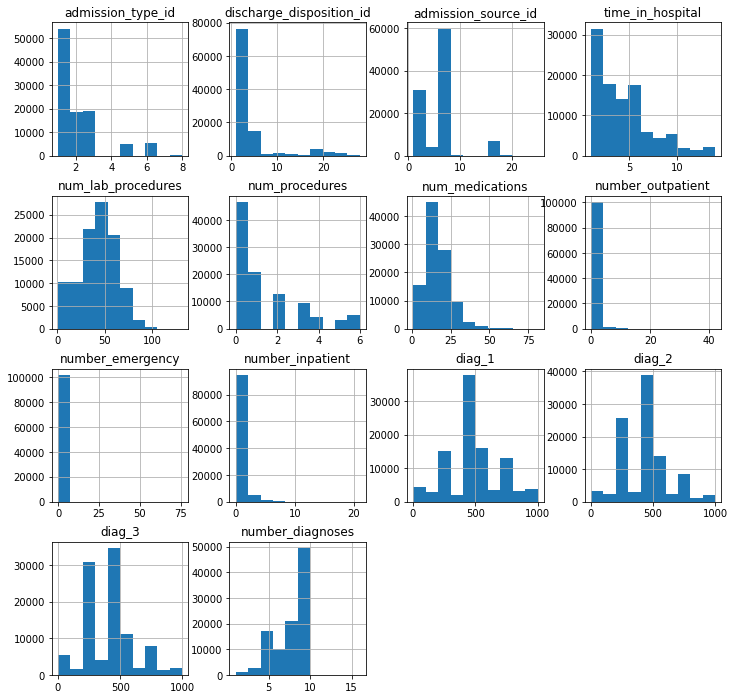

In [33]:
X[varc].hist(figsize=(12,12))

#### Missing values

In [34]:
miss = 1 - X[varc].describe().T[['count']] / len(X)
miss

,count
admission_type_id,0.000000
discharge_disposition_id,0.000000
admission_source_id,0.000000
time_in_hospital,0.000000
num_lab_procedures,0.000000
num_procedures,0.000000
num_medications,0.000000
number_outpatient,0.000000
number_emergency,0.000000
number_inpatient,0.000000


In [35]:
X.shape, X.dropna().shape, X.dropna().shape[0] / X.shape[0]

((101766, 14), (100244, 14), 0.9850441208262092)

#### Imputing missing values

In [36]:
im = SimpleImputer()

In [37]:
im.fit(X)

SimpleImputer()

In [38]:
X[varc] = im.transform(X[varc])

In [39]:
X.shape, X.dropna().shape, X.dropna().shape[0] / X.shape[0]

((101766, 14), (101766, 14), 1.0)

##### Validating distribution was not altered

In [40]:
ks = pd.DataFrame( map(lambda v:  (v , ks_2samp(df[v].dropna() , X[v]  ).statistic  ) , varc    ) , columns= ['var','ks']    )

In [41]:
#Distribution not altered as ks less than 0.1
ks

,var,ks
0,admission_type_id,0.000000
1,discharge_disposition_id,0.000000
2,admission_source_id,0.000000
3,time_in_hospital,0.000000
4,num_lab_procedures,0.000000
5,num_procedures,0.000000
6,num_medications,0.000000
7,number_outpatient,0.000000
8,number_emergency,0.000000
9,number_inpatient,0.000000


#### Variance

In [42]:
vt = VarianceThreshold(threshold=1.0)

In [43]:
vt.fit(X[varc])

VarianceThreshold(threshold=1.0)

In [44]:
wo_variance = [v for v, u in zip( varc , vt.get_support() ) if not(u) ]
wo_variance

['number_emergency']

array([[<AxesSubplot:title={'center':'number_emergency'}>]], dtype=object)

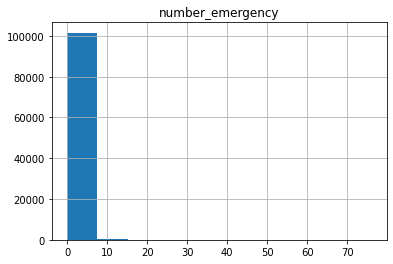

In [45]:
X[wo_variance].hist()

In [46]:
X.drop(wo_variance, axis=1, inplace=True)

In [47]:
varc = [v for v in varc if v not in wo_variance]
varc

['admission_type_id',
 'discharge_disposition_id',
 'admission_source_id',
 'time_in_hospital',
 'num_lab_procedures',
 'num_procedures',
 'num_medications',
 'number_outpatient',
 'number_inpatient',
 'diag_1',
 'diag_2',
 'diag_3',
 'number_diagnoses']

#### Outliers

##### Cerca Intercuartil

In [48]:
# k=2 (moderado) ,  k=3 (fuerte)
k = 2
ext = X[varc].describe(percentiles=[0.25,0.75]).T[['25%','75%','mean']].reset_index()
ext['IQR'] = ext['75%'] - ext['25%'] 
ext['li']  = ext['mean'] - k*ext['IQR']
ext['ls']  = ext['mean'] + k*ext['IQR']
ext = ext[['index','li','ls']]

In [49]:
for v, li, ls in ext.values:
    X[f'ol_{v}'] = (( X[v] < li ) | ( X[v] > ls ) ).astype(int)

X['ext_iqr'] =  X.filter(like='ol_').max(axis=1)
X.drop(X.filter(like='ol_').columns, axis=1 , inplace=True)

In [50]:
X['ext_iqr'].value_counts()

1    101766
Name: ext_iqr, dtype: int64

##### Cerca Percentil

In [51]:
ext = X[varc].describe(percentiles=[0.005,0.995]).T[['0.5%','99.5%']].reset_index()
for v, li, ls in ext.values:
    X[f'ol_{v}'] = ( (X[v]<li) | (X[v]>ls)  ).astype(int)
    
X['ext'] = X.filter(like='ol_').max(axis=1)

In [52]:
X.drop(X.filter(like='ol_').columns, axis=1, inplace=True)

In [53]:
X['ext'].value_counts(True)

0    0.958493
1    0.041507
Name: ext, dtype: float64

##### Adding UM before deleting data

In [54]:
X[um] = df[um]

##### Deleting outliers

In [55]:
X = X.loc[X["ext"] == 0].reset_index(drop=True).drop(["ext", "ext_iqr"], axis=1)

In [56]:
X.shape

(97542, 14)

array([[<AxesSubplot:title={'center':'admission_type_id'}>,
        <AxesSubplot:title={'center':'discharge_disposition_id'}>,
        <AxesSubplot:title={'center':'admission_source_id'}>,
        <AxesSubplot:title={'center':'time_in_hospital'}>],
       [<AxesSubplot:title={'center':'num_lab_procedures'}>,
        <AxesSubplot:title={'center':'num_procedures'}>,
        <AxesSubplot:title={'center':'num_medications'}>,
        <AxesSubplot:title={'center':'number_outpatient'}>],
       [<AxesSubplot:title={'center':'number_inpatient'}>,
        <AxesSubplot:title={'center':'diag_1'}>,
        <AxesSubplot:title={'center':'diag_2'}>,
        <AxesSubplot:title={'center':'diag_3'}>],
       [<AxesSubplot:title={'center':'number_diagnoses'}>,
        <AxesSubplot:title={'center':'encounter_id'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

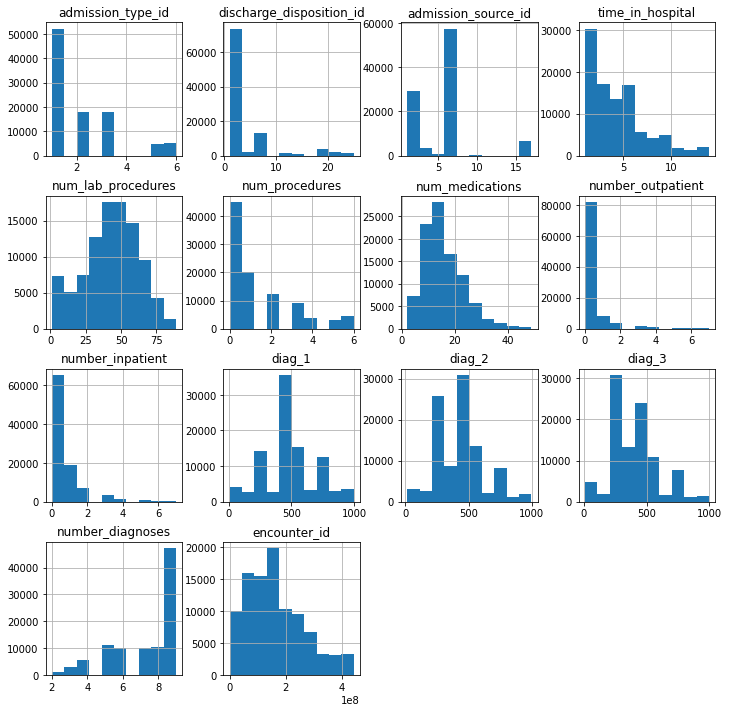

In [57]:
X.hist(figsize=(12,12))

### Bivariate Analysis

In [58]:
X[varc].corr()

,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses
admission_type_id,1.000000,0.089469,0.117676,-0.011798,-0.161593,0.126503,0.075365,0.042662,-0.035982,-0.005003,-0.005765,-0.003513,-0.112518
discharge_disposition_id,0.089469,1.000000,0.025985,0.163383,0.019667,0.013149,0.105655,-0.010034,0.026339,0.011961,0.025721,0.029235,0.043103
admission_source_id,0.117676,0.025985,1.000000,-0.010652,0.041422,-0.143073,-0.055014,0.048600,0.035781,0.019418,-0.008489,0.015926,0.070422
time_in_hospital,-0.011798,0.163383,-0.010652,1.000000,0.303867,0.172834,0.455252,-0.016099,0.082764,-0.120230,0.067452,0.084245,0.213647
num_lab_procedures,-0.161593,0.019667,0.041422,0.303867,1.000000,0.038878,0.250810,-0.020396,0.045791,-0.063098,0.018468,0.043302,0.148716
num_procedures,0.126503,0.013149,-0.143073,0.172834,0.038878,1.000000,0.354669,-0.029727,-0.067318,-0.004696,0.049860,0.028513,0.063127
num_medications,0.075365,0.105655,-0.055014,0.455252,0.250810,0.354669,1.000000,0.053804,0.079732,0.011834,0.075340,0.069496,0.261460
number_outpatient,0.042662,-0.010034,0.048600,-0.016099,-0.020396,-0.029727,0.053804,1.000000,0.122677,0.001530,0.029381,0.031452,0.099919
number_inpatient,-0.035982,0.026339,0.035781,0.082764,0.045791,-0.067318,0.079732,0.122677,1.000000,-0.038589,0.010592,0.013919,0.116276
diag_1,-0.005003,0.011961,0.019418,-0.120230,-0.063098,-0.004696,0.011834,0.001530,-0.038589,1.000000,0.027551,0.019864,-0.003466


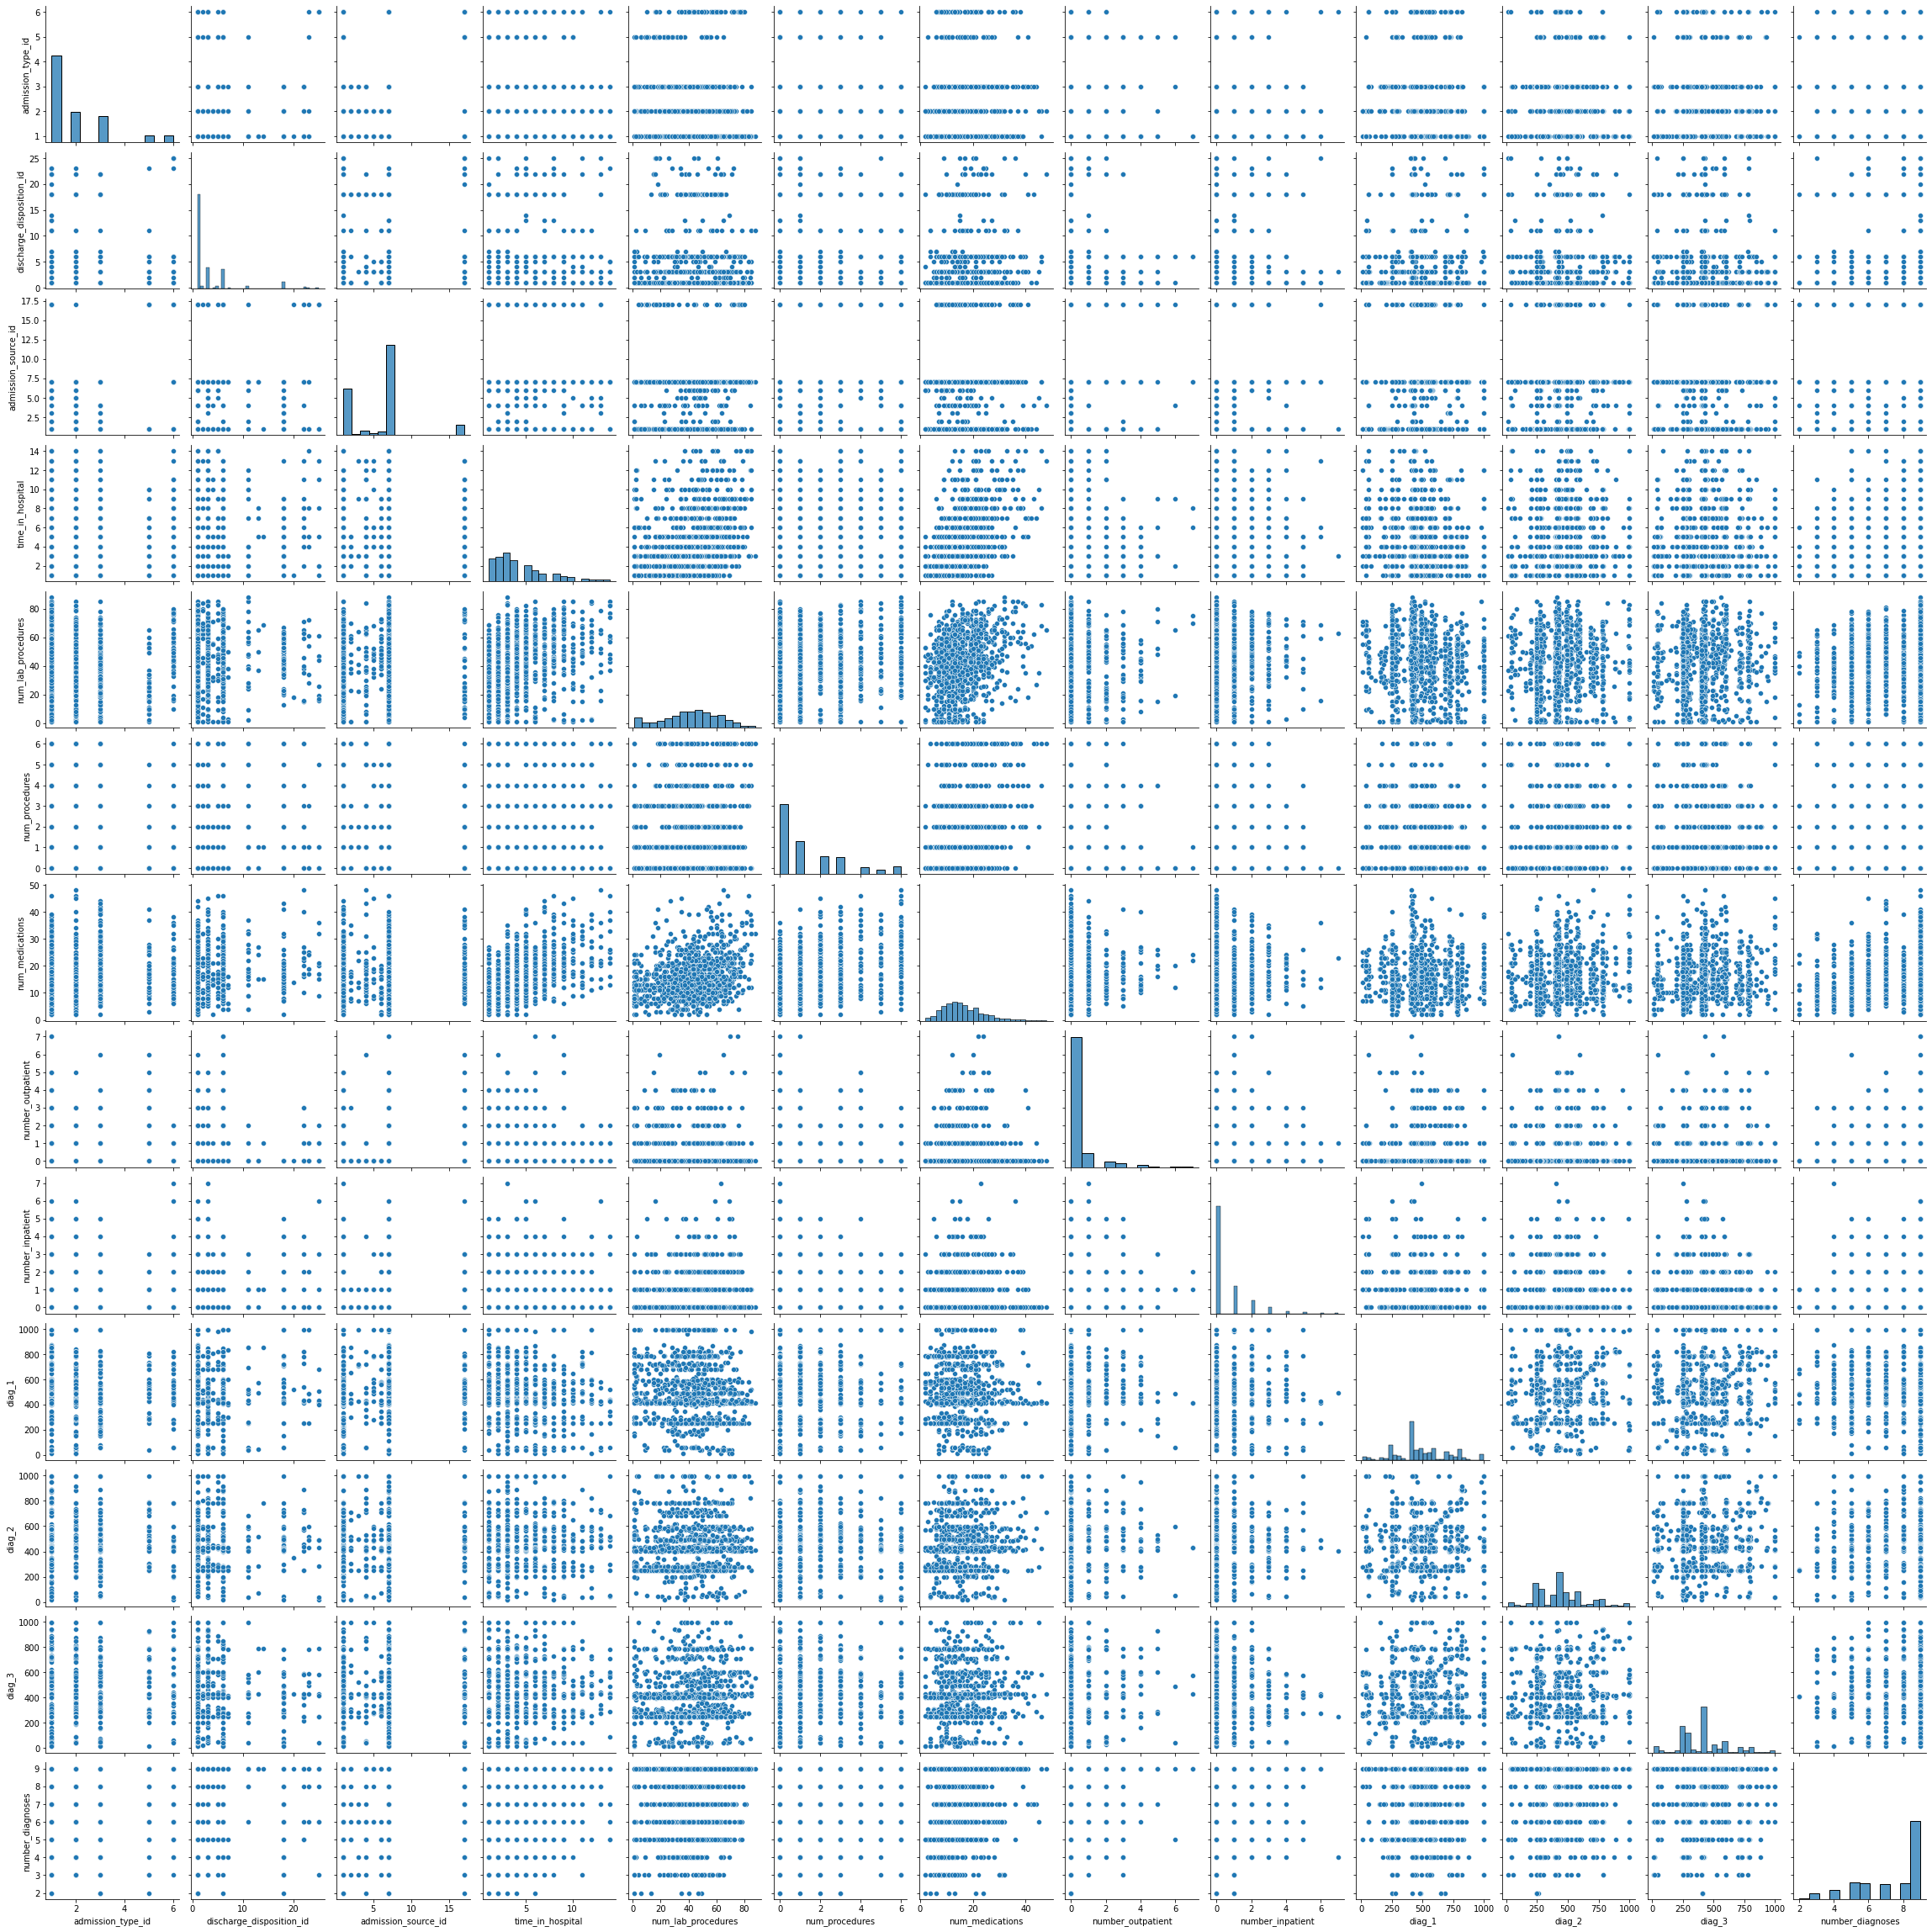

In [59]:
sns.pairplot(X[varc].sample(1000))

### Multicolinealidad

In [60]:
vc = VarClusHi(df=X[varc], feat_list = varc)

In [61]:
vc.varclus()

In [62]:
rs = vc.rsquare
rs = rs.sort_values(by=['Cluster','RS_Ratio'] , ascending=[1,1]).reset_index(drop=True)

In [63]:
rs['id'] = rs.groupby('Cluster').cumcount()+1

In [64]:
rs

,Cluster,Variable,RS_Own,RS_NC,RS_Ratio,id
0,0,time_in_hospital,0.658325,0.037259,0.354898,1
1,0,num_medications,0.590512,0.125790,0.468409,2
2,0,num_lab_procedures,0.378203,0.012824,0.629875,3
3,0,discharge_disposition_id,0.097236,0.005963,0.908179,4
4,1,number_diagnoses,0.509207,0.077225,0.531866,1
5,1,diag_3,0.400956,0.008344,0.604084,2
6,1,diag_2,0.368009,0.005861,0.635717,3
7,2,admission_type_id,0.558838,0.016003,0.448337,1
8,2,admission_source_id,0.558838,0.020470,0.450381,2
9,3,number_outpatient,0.561338,0.007278,0.441878,1


In [65]:
varc = rs.loc[ rs['id'] == 1 ]['Variable'].tolist()

array([[<AxesSubplot:title={'center':'time_in_hospital'}>,
        <AxesSubplot:title={'center':'number_diagnoses'}>],
       [<AxesSubplot:title={'center':'admission_type_id'}>,
        <AxesSubplot:title={'center':'number_outpatient'}>],
       [<AxesSubplot:title={'center':'diag_1'}>,
        <AxesSubplot:title={'center':'num_procedures'}>]], dtype=object)

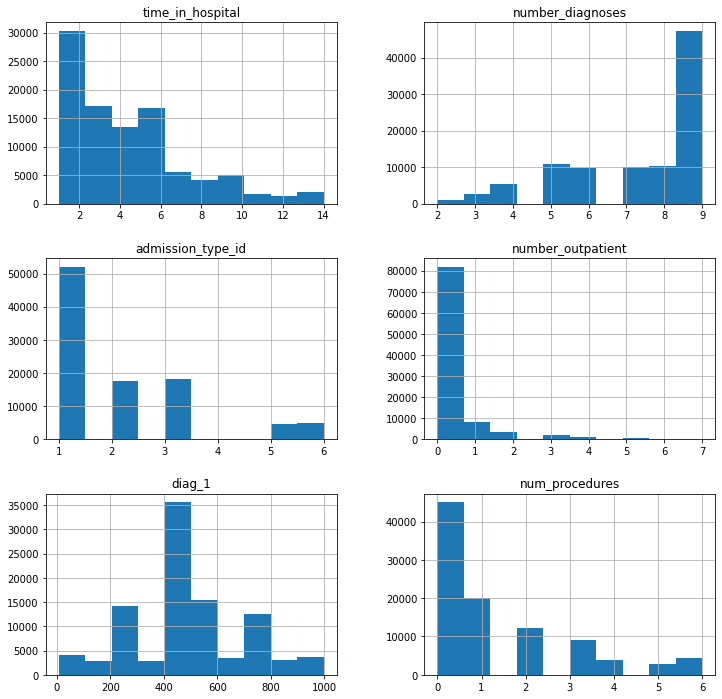

In [66]:
X[varc].hist(figsize=(12,12))

### Discretizing

In [67]:
for v in varc:
    for k in range(2,4):
        X = discretizar(X,v,k)

In [68]:
X.head()

,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,encounter_id,d_time_in_hospital_2,d_time_in_hospital_3,d_number_diagnoses_2,d_number_diagnoses_3,d_admission_type_id_2,d_admission_type_id_3,d_number_outpatient_2,d_number_outpatient_3,d_diag_1_2,d_diag_1_3,d_num_procedures_2,d_num_procedures_3
0,3.0,1.0,1.0,2.0,3.0,0.0,3.0,0.0,0.0,250.02,276.0,79.000000,3.0,53963346,"(0.999, 6.154]","(0.999, 4.467]","(1.999, 6.709]","(1.999, 4.725]","(0.999, 3.566]","(2.127, 4.26]","(-0.001, 2.028]","(-0.001, 1.361]","(7.999, 542.509]","(7.999, 342.774]","(-0.001, 2.358]","(-0.001, 1.49]"
1,1.0,1.0,7.0,1.0,50.0,0.0,8.0,0.0,0.0,250.13,276.0,409.669227,2.0,42008934,"(0.999, 6.154]","(0.999, 4.467]","(1.999, 6.709]","(1.999, 4.725]","(0.999, 3.566]","(0.999, 2.127]","(-0.001, 2.028]","(-0.001, 1.361]","(7.999, 542.509]","(7.999, 342.774]","(-0.001, 2.358]","(-0.001, 1.49]"
2,1.0,1.0,7.0,1.0,33.0,0.0,4.0,0.0,0.0,250.13,276.0,558.000000,3.0,68750328,"(0.999, 6.154]","(0.999, 4.467]","(1.999, 6.709]","(1.999, 4.725]","(0.999, 3.566]","(0.999, 2.127]","(-0.001, 2.028]","(-0.001, 1.361]","(7.999, 542.509]","(7.999, 342.774]","(-0.001, 2.358]","(-0.001, 1.49]"
3,1.0,1.0,7.0,1.0,55.0,0.0,3.0,0.0,1.0,250.13,276.0,409.669227,2.0,89254374,"(0.999, 6.154]","(0.999, 4.467]","(1.999, 6.709]","(1.999, 4.725]","(0.999, 3.566]","(0.999, 2.127]","(-0.001, 2.028]","(-0.001, 1.361]","(7.999, 542.509]","(7.999, 342.774]","(-0.001, 2.358]","(-0.001, 1.49]"
4,1.0,1.0,1.0,4.0,48.0,0.0,9.0,0.0,0.0,250.13,276.0,276.000000,3.0,71004000,"(0.999, 6.154]","(0.999, 4.467]","(1.999, 6.709]","(1.999, 4.725]","(0.999, 3.566]","(0.999, 2.127]","(-0.001, 2.028]","(-0.001, 1.361]","(7.999, 542.509]","(7.999, 342.774]","(-0.001, 2.358]","(-0.001, 1.49]"


In [69]:
vari = X.filter(like='d_').columns.tolist()

In [70]:
vari

['d_time_in_hospital_2',
 'd_time_in_hospital_3',
 'd_number_diagnoses_2',
 'd_number_diagnoses_3',
 'd_admission_type_id_2',
 'd_admission_type_id_3',
 'd_number_outpatient_2',
 'd_number_outpatient_3',
 'd_diag_1_2',
 'd_diag_1_3',
 'd_num_procedures_2',
 'd_num_procedures_3']

In [71]:
df.shape, X.shape

((101766, 82), (97542, 26))

## Predictive Power

### X and Y

In [72]:
X = X[um+vari].merge(  df[um+varn] , on = um , how='left' ).reset_index(drop=True)
y = X[um].merge(df[um+tgt], on=um, how='left').reset_index(drop=True)

In [73]:
X.shape, y.shape

((97542, 29), (97542, 2))

#### Train, test split

In [74]:
Xt, Xv, yt, yv = train_test_split(X, y, train_size=0.7 )

In [75]:
Xt = Xt.merge( yt, on=um, how='inner' ).reset_index(drop=True)

In [76]:
Xt.head()

,encounter_id,d_time_in_hospital_2,d_time_in_hospital_3,d_number_diagnoses_2,d_number_diagnoses_3,d_admission_type_id_2,d_admission_type_id_3,d_number_outpatient_2,d_number_outpatient_3,d_diag_1_2,d_diag_1_3,d_num_procedures_2,d_num_procedures_3,n_race,n_gender,n_age,n_payer_code,n_medical_specialty,n_max_glu_serum,n_A1Cresult,n_metformin,n_glimepiride,n_glipizide,n_glyburide,n_pioglitazone,n_rosiglitazone,n_insulin,n_change,n_readmitted,diabetesMed
0,273567702,"(0.999, 6.154]","(0.999, 4.467]","(6.709, 9.0]","(7.397, 9.0]","(0.999, 3.566]","(2.127, 4.26]","(-0.001, 2.028]","(-0.001, 1.361]","(7.999, 542.509]","(342.774, 634.367]","(-0.001, 2.358]","(-0.001, 1.49]",Caucasian,Male,[60-70),MC,SIN CATEGORIA,None,None,No,No,No,No,No,No,Steady,No,>30,Yes
1,156365130,"(0.999, 6.154]","(0.999, 4.467]","(6.709, 9.0]","(7.397, 9.0]","(0.999, 3.566]","(0.999, 2.127]","(-0.001, 2.028]","(-0.001, 1.361]","(7.999, 542.509]","(7.999, 342.774]","(-0.001, 2.358]","(-0.001, 1.49]",AfricanAmerican,Male,[40-50),SIN CATEGORIA,SMALL_CATEGORIES,None,None,No,No,No,No,No,No,Up,Ch,<30,Yes
2,39582588,"(0.999, 6.154]","(4.467, 9.006]","(6.709, 9.0]","(7.397, 9.0]","(0.999, 3.566]","(0.999, 2.127]","(-0.001, 2.028]","(-0.001, 1.361]","(7.999, 542.509]","(342.774, 634.367]","(-0.001, 2.358]","(-0.001, 1.49]",Caucasian,Female,[70-80),SIN CATEGORIA,Family/GeneralPractice,None,None,No,No,No,Steady,No,No,No,No,<30,Yes
3,99211356,"(0.999, 6.154]","(0.999, 4.467]","(1.999, 6.709]","(4.725, 7.397]","(0.999, 3.566]","(0.999, 2.127]","(-0.001, 2.028]","(-0.001, 1.361]","(7.999, 542.509]","(342.774, 634.367]","(2.358, 6.0]","(1.49, 4.139]",AfricanAmerican,Male,[80-90),HM,InternalMedicine,None,None,No,No,No,No,No,No,Steady,Ch,NO,Yes
4,441473204,"(0.999, 6.154]","(0.999, 4.467]","(1.999, 6.709]","(1.999, 4.725]","(0.999, 3.566]","(2.127, 4.26]","(-0.001, 2.028]","(-0.001, 1.361]","(7.999, 542.509]","(7.999, 342.774]","(-0.001, 2.358]","(-0.001, 1.49]",AfricanAmerican,Male,[40-50),SMALL_CATEGORIES,SMALL_CATEGORIES,None,None,No,No,No,No,No,No,Up,Ch,NO,Yes


### Best discretized variables (IV Function)

In [77]:
aux = Xt.pivot_table( index = "d_admission_type_id_3" , 
                          columns = tgt , 
                          values = um , 
                         aggfunc = 'count', 
                         fill_value = 0 )

In [78]:
aux

encounter_id       
diabetesMed                     No    Yes
d_admission_type_id_3                    
(0.999, 2.127]               11199  37607
(2.127, 4.26]                 2889   9827
(4.26, 6.0]                   1603   5154

In [79]:
aux[list(range(2))] = aux/aux.apply(np.sum)

In [80]:
aux

encounter_id                0         1
diabetesMed                     No    Yes                    
d_admission_type_id_3                                        
(0.999, 2.127]               11199  37607  0.713721  0.715125
(2.127, 4.26]                 2889   9827  0.184118  0.186868
(4.26, 6.0]                   1603   5154  0.102160  0.098007

In [81]:
aux[0]

d_admission_type_id_3
(0.999, 2.127]    0.713721
(2.127, 4.26]     0.184118
(4.26, 6.0]       0.102160
Name: 0, dtype: float64

In [82]:
aux[1]

d_admission_type_id_3
(0.999, 2.127]    0.715125
(2.127, 4.26]     0.186868
(4.26, 6.0]       0.098007
Name: 1, dtype: float64

In [83]:
aux['w'] = np.log( aux[0] / aux[1] )
aux

encounter_id                0         1         w
diabetesMed                     No    Yes                              
d_admission_type_id_3                                                  
(0.999, 2.127]               11199  37607  0.713721  0.715125 -0.001965
(2.127, 4.26]                 2889   9827  0.184118  0.186868 -0.014823
(4.26, 6.0]                   1603   5154  0.102160  0.098007  0.041504

In [84]:
aux['iv'] = ( aux[0] - aux[1] ) * aux['w']
aux

encounter_id                0         1         w  \
diabetesMed                     No    Yes                                 
d_admission_type_id_3                                                     
(0.999, 2.127]               11199  37607  0.713721  0.715125 -0.001965   
(2.127, 4.26]                 2889   9827  0.184118  0.186868 -0.014823   
(4.26, 6.0]                   1603   5154  0.102160  0.098007  0.041504   

                             iv  
diabetesMed                      
d_admission_type_id_3            
(0.999, 2.127]         0.000003  
(2.127, 4.26]          0.000041  
(4.26, 6.0]            0.000172

In [85]:
iv = pd.DataFrame( map( lambda v: calculo_iv(Xt,v,tgt,um[0]), vari  ), columns=['variable','iv']  )
iv['raiz'] = iv['variable'].map(lambda x: '_'.join(x.split('_')[1:2] )  )
iv = iv.sort_values(by=['raiz','iv'],ascending=[1,0]).reset_index(drop=True)

In [86]:
iv['id'] = iv.groupby('raiz').cumcount()+1
iv = iv.loc[iv['id'] == 1]

In [87]:
besti = iv['variable'].tolist()
len(besti), besti

(5,
 ['d_admission_type_id_3',
  'd_diag_1_2',
  'd_num_procedures_3',
  'd_number_diagnoses_3',
  'd_time_in_hospital_3'])

#### Train, test split

In [88]:
Xt, Xv,yt,yv = train_test_split(X,y,train_size=0.7)

In [89]:
Xt = Xt.merge(yt,on=um,how='inner')

### Best normalized variables

In [90]:
ivd = pd.DataFrame(map(lambda v:calculo_iv(Xt,v,tgt,um[0]),varn),columns=['variable','iv'])

/home/davidrm/Documents/envs/diplo/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/davidrm/Documents/envs/diplo/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/davidrm/Documents/envs/diplo/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/davidrm/Documents/envs/diplo/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/davidrm/Documents/envs/diplo/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/davidrm/D

In [91]:
ivd

,variable,iv
0,n_race,0.001654
1,n_gender,0.001391
2,n_age,0.004867
3,n_payer_code,0.049198
4,n_medical_specialty,0.012521
5,n_max_glu_serum,0.001355
6,n_A1Cresult,0.067354
7,n_metformin,inf
8,n_glimepiride,inf
9,n_glipizide,inf


In [92]:
iv = pd.concat([iv,ivd],ignore_index=True)
#iv = iv.loc[iv['iv'] != np.inf].reset_index(drop=True)
iv = iv.loc[~np.isinf(iv['iv'])].reset_index(drop=True)

In [93]:
iv.drop(['raiz','id'],axis=1,inplace=True)

In [94]:
iv.sort_values(by='iv',ascending=False)

,variable,iv
11,n_A1Cresult,0.067354
8,n_payer_code,0.049198
12,n_readmitted,0.020956
4,d_time_in_hospital_3,0.013764
9,n_medical_specialty,0.012521
1,d_diag_1_2,0.009555
7,n_age,0.004867
3,d_number_diagnoses_3,0.003458
2,d_num_procedures_3,0.002633
5,n_race,0.001654


In [95]:
#With iv > 0.1 it would show no best variables, and even with this, it would not show the best discrete variables
#We're adding manually those variables + the best normalized
temp = iv.loc[ (iv['iv'] > 0.02 ) &  ( iv['iv'] < 0.8) ]['variable'].tolist()

In [96]:
best = besti+temp

In [97]:
best

['d_admission_type_id_3',
 'd_diag_1_2',
 'd_num_procedures_3',
 'd_number_diagnoses_3',
 'd_time_in_hospital_3',
 'n_payer_code',
 'n_A1Cresult',
 'n_readmitted']

## WoE Transformation

In [98]:
X = X[um + best].reset_index(drop=True)

In [99]:
X.shape, y.shape

((97542, 9), (97542, 2))

In [100]:
Xt, Xv,yt,yv = train_test_split(X,y,train_size=0.7)

In [101]:
Xt = Xt.merge(yt,on=um,how='inner')

### WoW map

In [102]:
woe_map = list(map( lambda v: codificacion_woe(  Xt , v, tgt, um[0] ), best  ))

In [103]:
for v, mapa in woe_map:
    Xt[f'w_{v}'] = Xt[v].replace(mapa)
    Xv[f'w_{v}'] = Xv[v].replace(mapa)

In [104]:
varw = Xt.filter(like='w_').columns.tolist()

In [105]:
varw

['w_d_admission_type_id_3',
 'w_d_diag_1_2',
 'w_d_num_procedures_3',
 'w_d_number_diagnoses_3',
 'w_d_time_in_hospital_3',
 'w_n_payer_code',
 'w_n_A1Cresult',
 'w_n_readmitted']

## TAD

In [106]:
tad = Xt[um + varw].merge(yt, on = um, how='inner').reset_index(drop=True)

In [107]:
tad

,encounter_id,w_d_admission_type_id_3,w_d_diag_1_2,w_d_num_procedures_3,w_d_number_diagnoses_3,w_d_time_in_hospital_3,w_n_payer_code,w_n_A1Cresult,w_n_readmitted,diabetesMed
0,171023100,-0.006725,0.137878,-0.036924,-0.054498,0.086119,-0.169919,0.068071,0.134824,No
1,62050308,-0.006725,-0.077495,0.092097,0.075083,0.086119,0.218206,0.068071,0.134824,Yes
2,58852524,0.046970,-0.077495,-0.036924,0.075083,0.086119,0.218206,0.068071,0.134824,Yes
3,87305058,-0.006725,-0.077495,-0.036924,-0.054498,0.086119,0.218206,0.068071,-0.176154,Yes
4,4361868,0.046970,0.137878,0.002458,-0.054498,-0.138440,0.218206,0.068071,0.134824,Yes
...,...,...,...,...,...,...,...,...,...,...
68274,60670074,-0.006725,-0.077495,0.092097,0.075083,0.086119,0.218206,-0.999300,0.134824,Yes
68275,172786044,-0.006725,-0.077495,-0.036924,-0.054498,-0.138440,0.247052,0.068071,0.134824,Yes
68276,407904680,0.000406,0.137878,-0.036924,0.077245,0.086119,-0.261590,0.000026,0.134824,Yes
68277,194612040,-0.006725,-0.077495,0.002458,-0.054498,0.086119,-0.169919,0.000026,0.134824,Yes


In [108]:
pd.to_pickle(tad  , 'RINCON_MORALES_DAVID_examen.pkl' , protocol=4  )